# Escolha de modelos e análise de erros

Nesta fase vamos fazer o seguinte:

- Construir uma *pipeline* de processamento dos dados;
- Elencar alguns modelos a serem analisados;
- Fazer mais uma separação de dados. Desta vez vamos dividir o conjunto de treino em dois: treino e validação;
- Escolher o melhor modelo baseado no erro no conjunto de validação;
- Analisar o *resíduo*: a diferença entre o valor predito e o valor real. Será que tem algum padrão residual aqui?

Primeiro, vamos carregar os dados pré-processados:

In [17]:
from pathlib import Path

import pandas as pd
from lab01.config import DATA_DIR
from lab01.dataloader import load_preprocessed_data

In [18]:
def load_X_y(data_dir: Path) -> tuple[pd.DataFrame, pd.Series]:
    data = load_preprocessed_data(DATA_DIR)
    X = data.drop(columns=['log_median_house_value'])
    y = data['log_median_house_value']
    return X, y


X, y = load_X_y(DATA_DIR)

Vamos agora dividir os dados em treino e teste, e dividir novamente em treino (final) e validação.

In [19]:
from sklearn.model_selection import train_test_split


def split_data(
    X,
    y,
    test_size=0.2,
    random_seed=42,
) -> tuple[
        pd.DataFrame,
        pd.DataFrame,
        pd.Series,
        pd.Series,
]:
    return train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_seed,
    )


X_train, X_test, y_train, y_test = split_data(X, y)
X_train_val, X_test_val, y_train_val, y_test_val = split_data(X_train, y_train)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [21]:
numerical_cols = [
    'longitude',
    'latitude',
    'housing_median_age',
    'log_households',
    'log_median_income',
    'log_rooms_per_household',
    'log_population_per_household',
    'log_bedrooms_per_room',
]

categorical_cols = [
    'ocean_proximity',
]
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False)),
])

preprocessing_pipe = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols),
    ],
    remainder='passthrough',
)

preprocessing_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'log_households', 'log_median_income',
                                  'log_rooms_per_household',
                                  'log_population_per_household',
                                  'log_bedrooms_per_room']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['ocean_proximity'])])

In [22]:
preprocessing_pipe.fit(X_train_val)

preprocessing_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'log_households', 'log_median_income',
                                  'log_rooms_per_household',
                                  'log_population_per_household',
                                  'log_bedrooms_per_room']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['ocean_proximity'])])

## Escolha de modelos

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', LinearRegression()),
])

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', DecisionTreeRegressor(random_state=42)),
])

In [25]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', RandomForestRegressor(random_state=42, n_jobs=-1)),
])

In [26]:
from typing import Any

experiments: list[dict[str, Any]] = [
    {
        'name': 'Linear Regression',
        'model': lin_reg,
    },
    {
        'name': 'Decision Tree',
        'model': tree_reg,
    },
    {
        'name': 'Random Forest',
        'model': forest_reg
    },
]

In [27]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import root_mean_squared_error


def train_and_evaluate_model(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: np.array,
    X_val: pd.DataFrame,
    y_val: np.array,
) -> float:
    '''Trains and evaluates a model.

    Args:
        model: A scikit-learn model.
        X_train: The training features.
        y_train: The training target.
        X_val: The validation features.
        y_val: The validation target.

    Returns:
        The root mean squared error of the model on the validation set.
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [28]:
for experiment in experiments:
    name = experiment['name']
    model = experiment['model']

    rmse = train_and_evaluate_model(
        model,
        X_train_val,
        y_train_val,
        X_test_val,
        y_test_val,
    )
    percentage_error = 100.0 * (10.0**rmse - 1.0)

    experiment['rmse'] = rmse

    print(f'{name}: '
          f'RMSE = {rmse:.4f}, '
          f'Percentage Error = {percentage_error:.2f}%')

Linear Regression: RMSE = 0.1243, Percentage Error = 33.15%
Decision Tree: RMSE = 0.1259, Percentage Error = 33.62%
Random Forest: RMSE = 0.0905, Percentage Error = 23.17%


In [29]:
best_model = min(experiments, key=lambda x: x['rmse'])
print(f'\nBest model: {best_model["name"]}')


Best model: Random Forest


In [30]:
model = best_model['model']

model.fit(X_train_val, y_train_val)
y_pred = model.predict(X_test_val)

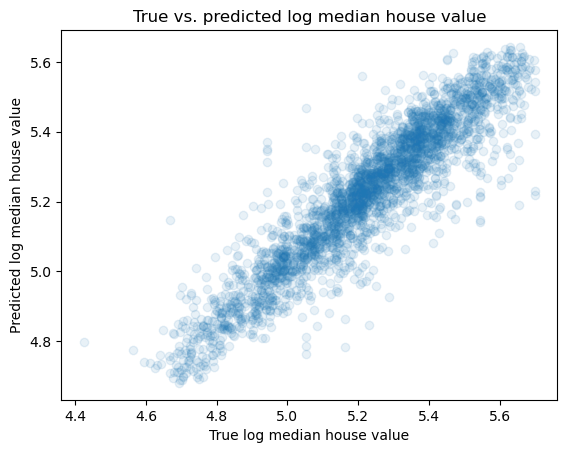

In [31]:
import matplotlib.pyplot as plt

plt.scatter(y_test_val, y_pred, alpha=0.1)
plt.xlabel('True log median house value')
plt.ylabel('Predicted log median house value')
plt.title('True vs. predicted log median house value')
plt.show()

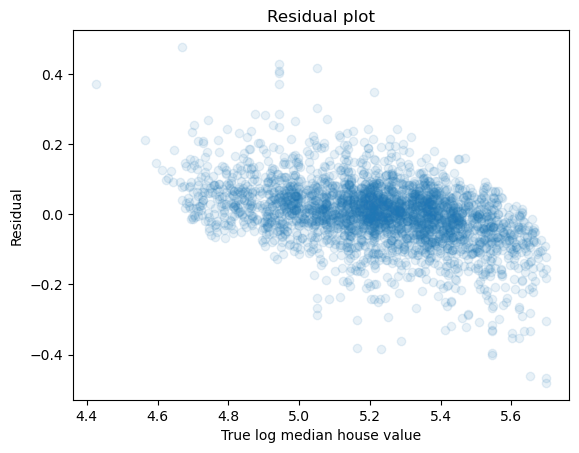

In [32]:
import matplotlib.pyplot as plt

plt.scatter(y_test_val, y_pred - y_test_val, alpha=0.1)
plt.xlabel('True log median house value')
plt.ylabel('Residual')
plt.title('Residual plot')
plt.show()

## Avaliação